In [10]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from keras.models import Model
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler




import matplotlib.pyplot as plt

In [15]:
import psutil

# Utilisation de la mémoire en pourcentage
print(f"Utilisation de la mémoire: {psutil.virtual_memory().percent}%")

# Utilisation détaillée de la mémoire
memory_info = psutil.virtual_memory()
print(f"Mémoire totale: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Mémoire disponible: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Mémoire utilisée: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Mémoire libre: {memory_info.free / (1024 ** 3):.2f} GB")

Utilisation de la mémoire: 68.2%
Mémoire totale: 15.70 GB
Mémoire disponible: 4.99 GB
Mémoire utilisée: 10.71 GB
Mémoire libre: 4.99 GB


In [ ]:
import gc

# Libérer la mémoire 
del images, labels
gc.collect()

In [3]:
# Paramètres
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 3  # Nombre de classes mis à jour
BATCH_SIZE = 32
EPOCHS = 100


In [4]:
# Chemins des dossiers 
covid_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/images'
covid_mask = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/masks'
normal_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Normal/images'
normal_mask = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Normal/masks'
lung_opacity_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/images'
lung_opacity_mask = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/masks'
viral_pneumonia_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
viral_pneumonia_mask = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/masks'

In [5]:
# Vérification des chemins pour les images
paths = [covid_path, normal_path, lung_opacity_path, viral_pneumonia_path]
for path in paths:
    if os.path.exists(path):
        print(f"Img chemin existe: {path}")
    else:
        print(f"Img chemin n'existe pas: {path}")


# Vérification des chemins pour les masques 
mask_paths = [covid_mask, normal_mask, lung_opacity_mask, viral_pneumonia_mask]
for mask_path in mask_paths:
    if os.path.exists(mask_path):
        print(f"Mask chemin existe: {mask_path}")
    else:
        print(f"Mask chemin n'existe pas: {mask_path}")

Img chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/images
Img chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Normal/images
Img chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/images
Img chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/images
Mask chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/masks
Mask chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Normal/masks
Mask chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Lung_Opacity/masks
Mask chemin existe: /Users/adamj/Downloads/COVID-19_Radiography_Dataset/Viral Pneumonia/masks


In [10]:
# Tailles des images en Ko et Mo
def display_image_sizes(images):
    sizes_bytes = [img.nbytes for img in images]
    sizes_ko = [size / 1024 for size in sizes_bytes]
    sizes_mo = [size / (1024 * 1024) for size in sizes_bytes]
    
    for i, (size_b, size_ko, size_mo) in enumerate(zip(sizes_bytes, sizes_ko, sizes_mo)):
        print(f"Image {i+1} - Taille: {size_b} octets, {size_ko:.2f} Ko, {size_mo:.2f} Mo")

display_image_sizes(images[:10])  # Afficher les tailles des 10 premières images

NameError: name 'images' is not defined

In [6]:
# Fonction pour charger les images et les masques
def load_images_with_masks(image_dir, mask_dir, label, limit=None):
    image_data = []
    label_data = []
    image_files = os.listdir(image_dir)
    if limit:
        image_files = image_files[:limit]
    for file_name in image_files:
        if file_name.endswith('.png'):
            img_path = os.path.join(image_dir, file_name)
            mask_path = os.path.join(mask_dir, file_name)
            try:
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
                img = img / 255.0
                mask = mask / 255.0
                lung_only = img * np.expand_dims(mask, axis=-1)  # Garder uniquement la partie des poumons
                image_data.append(lung_only)
                label_data.append(label)
                # Calculer la taille de l'image
                image_size = os.path.getsize(img_path) / 1024  # Taille en Ko
                print(f"Taille de l'image {file_name}: {image_size:.2f} Ko")
            except Exception as e:
                print(f"Erreur de chargement de l'image {file_name} ou du masque : {e}")
    return np.array(image_data), np.array(label_data)

# Fonction pour charger les données de plusieurs répertoires avec masques
def load_data_with_masks(image_dirs, mask_dirs, labels, limits=None):
    all_images = []
    all_labels = []
    for i in range(len(image_dirs)):
        images, label_data = load_images_with_masks(image_dirs[i], mask_dirs[i], labels[i], limits[i])
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

# Nouvelles étiquettes après regroupement
new_labels = [0, 1, 2, 2]  # 0 pour COVID, 1 pour Normal, 2 pour Lung Opacity + Viral Pneumonia

# Définir les limites par classe
limits = [2500, 2500, 1250, 1250]  # 2500 images par classe

In [7]:
# Chargement et prétraitement des données avec les nouvelles étiquettes
images, labels = load_data_with_masks([covid_path, normal_path, lung_opacity_path, viral_pneumonia_path],
                                       [covid_mask, normal_mask, lung_opacity_mask, viral_pneumonia_mask],
                                       new_labels, limits)

Taille de l'image COVID-1.png: 27.55 Ko
Taille de l'image COVID-10.png: 35.60 Ko
Taille de l'image COVID-100.png: 32.09 Ko
Taille de l'image COVID-1000.png: 32.53 Ko
Taille de l'image COVID-1001.png: 32.56 Ko
Taille de l'image COVID-1002.png: 35.47 Ko
Taille de l'image COVID-1003.png: 36.71 Ko
Taille de l'image COVID-1004.png: 26.12 Ko
Taille de l'image COVID-1005.png: 39.18 Ko
Taille de l'image COVID-1006.png: 37.37 Ko
Taille de l'image COVID-1007.png: 30.58 Ko
Taille de l'image COVID-1008.png: 35.50 Ko
Taille de l'image COVID-1009.png: 34.16 Ko
Taille de l'image COVID-101.png: 35.57 Ko
Taille de l'image COVID-1010.png: 29.71 Ko
Taille de l'image COVID-1011.png: 35.89 Ko
Taille de l'image COVID-1012.png: 35.49 Ko
Taille de l'image COVID-1013.png: 28.53 Ko
Taille de l'image COVID-1014.png: 37.26 Ko
Taille de l'image COVID-1015.png: 26.83 Ko
Taille de l'image COVID-1016.png: 31.41 Ko
Taille de l'image COVID-1017.png: 40.58 Ko
Taille de l'image COVID-1018.png: 35.98 Ko
Taille de l'image 

In [6]:
# Fonction pour charger les images et les masques sans les données aberrantes
def load_images_with_masks(image_dir, mask_dir, label, exclude_files=None, limit=None):
    image_data = []
    label_data = []
    image_files = os.listdir(image_dir)
    if limit:
        image_files = image_files[:limit]
    if exclude_files is None:
        exclude_files = []
    for file_name in image_files:
        if file_name.endswith('.png') and file_name not in exclude_files:
            img_path = os.path.join(image_dir, file_name)
            mask_path = os.path.join(mask_dir, file_name)
            try:
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
                img = img / 255.0
                mask = mask / 255.0
                lung_only = img * np.expand_dims(mask, axis=-1)  # Garder uniquement la partie des poumons
                image_data.append(lung_only)
                label_data.append(label)
                # Calculer la taille de l'image
                image_size = os.path.getsize(img_path) / 1024  # Taille en Ko
                print(f"Taille de l'image {file_name}: {image_size:.2f} Ko")
            except Exception as e:
                print(f"Erreur de chargement de l'image {file_name} ou du masque : {e}")
    return np.array(image_data), np.array(label_data)

# Fonction pour charger les données de plusieurs répertoires avec masques
def load_data_with_masks(image_dirs, mask_dirs, labels, limits=None, exclude_files=None):
    all_images = []
    all_labels = []
    for i in range(len(image_dirs)):
        images, label_data = load_images_with_masks(image_dirs[i], mask_dirs[i], labels[i], exclude_files=exclude_files, limit=limits[i])
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

# Nouvelles étiquettes après regroupement
new_labels = [0, 1, 2, 2]  # 0 pour COVID, 1 pour Normal, 2 pour Lung Opacity + Viral Pneumonia

# Limites par classe
limits = [2500, 2500, 1250, 1250]  # 2500 images par classe

# Liste des fichiers à exclure (outliers)
exclude_files = ['outlier1.png', 'outlier2.png', 'COVID-135.png','COVID-509.png','COVID-604.png','COVID-653.png','COVID-686.png','COVID-697.png','COVID-1086.png','COVID-1127.png',

'COVID-1142.png','COVID-1179.png','COVID-1306.png','COVID-1318.png','COVID-1322.png','COVID-1336.png','COVID-1339.png','COVID-1348.png','COVID-1360.png',

'COVID-1363.png','COVID-1365.png','COVID-1368.png','COVID-1371.png','COVID-1377.png','COVID-1380.png','COVID-1393.png','COVID-1408.png','COVID-1414.png',

'COVID-1420.png','COVID-1426.png','COVID-1429.png','COVID-1436.png','COVID-1447.png','COVID-1450.png','COVID-1456.png','COVID-1462.png','COVID-1476.png',

'COVID-1479.png','COVID-1494.png','COVID-1500.png','COVID-1506.png','COVID-1509.png','COVID-1515.png','COVID-1518.png','COVID-1523.png','COVID-1536.png',

'COVID-1542.png','COVID-1548.png','COVID-1551.png','COVID-1554.png','COVID-1563.png','COVID-1599.png','COVID-1605.png','COVID-1616.png','COVID-1620.png',

'COVID-1630.png','COVID-1666.png','COVID-1674.png','COVID-1686.png','COVID-1692.png','COVID-1700.png','COVID-1702.png','COVID-1704.png','COVID-1706.png',

'COVID-1708.png','COVID-1714.png','COVID-1722.png','COVID-1756.png','COVID-1762.png','COVID-1770.png','COVID-1774.png','COVID-1783.png','COVID-1788.png',

'COVID-1801.png','COVID-1876.png','COVID-1914.png','COVID-1923.png','COVID-2107.png','COVID-2137.png','COVID-2153.png','COVID-2182.png','COVID-2280.png',

'COVID-2283.png','COVID-2324.png','COVID-2455.png','COVID-2468.png','COVID-2545.png','COVID-2549.png','COVID-2614.png','COVID-2696.png','COVID-2792.png',

'COVID-2817.png','COVID-2828.png','COVID-2900.png','COVID-2966.png','COVID-3013.png','COVID-3029.png','COVID-3052.png','COVID-3053.png','COVID-3112.png',

'COVID-3436.png','COVID-3506.png','COVID-3603.png','COVID-3606.png','COVID-3614.png','Viral Pneumonia-39.png','NORMAL-2316.png','NORMAL-8585.png']  # Remplacez par les noms de fichiers réels à 

# Charger les données en excluant les outliers
image_dirs = [covid_path, normal_path, lung_opacity_path, viral_pneumonia_path]
mask_dirs = [covid_mask, normal_mask, lung_opacity_mask, viral_pneumonia_mask]

images, labels = load_data_with_masks(image_dirs, mask_dirs, new_labels, limits=limits, exclude_files=exclude_files)

Taille de l'image COVID-1.png: 27.55 Ko
Taille de l'image COVID-10.png: 35.60 Ko
Taille de l'image COVID-100.png: 32.09 Ko
Taille de l'image COVID-1000.png: 32.53 Ko
Taille de l'image COVID-1001.png: 32.56 Ko
Taille de l'image COVID-1002.png: 35.47 Ko
Taille de l'image COVID-1003.png: 36.71 Ko
Taille de l'image COVID-1004.png: 26.12 Ko
Taille de l'image COVID-1005.png: 39.18 Ko
Taille de l'image COVID-1006.png: 37.37 Ko
Taille de l'image COVID-1007.png: 30.58 Ko
Taille de l'image COVID-1008.png: 35.50 Ko
Taille de l'image COVID-1009.png: 34.16 Ko
Taille de l'image COVID-101.png: 35.57 Ko
Taille de l'image COVID-1010.png: 29.71 Ko
Taille de l'image COVID-1011.png: 35.89 Ko
Taille de l'image COVID-1012.png: 35.49 Ko
Taille de l'image COVID-1013.png: 28.53 Ko
Taille de l'image COVID-1014.png: 37.26 Ko
Taille de l'image COVID-1015.png: 26.83 Ko
Taille de l'image COVID-1016.png: 31.41 Ko
Taille de l'image COVID-1017.png: 40.58 Ko
Taille de l'image COVID-1018.png: 35.98 Ko
Taille de l'image 

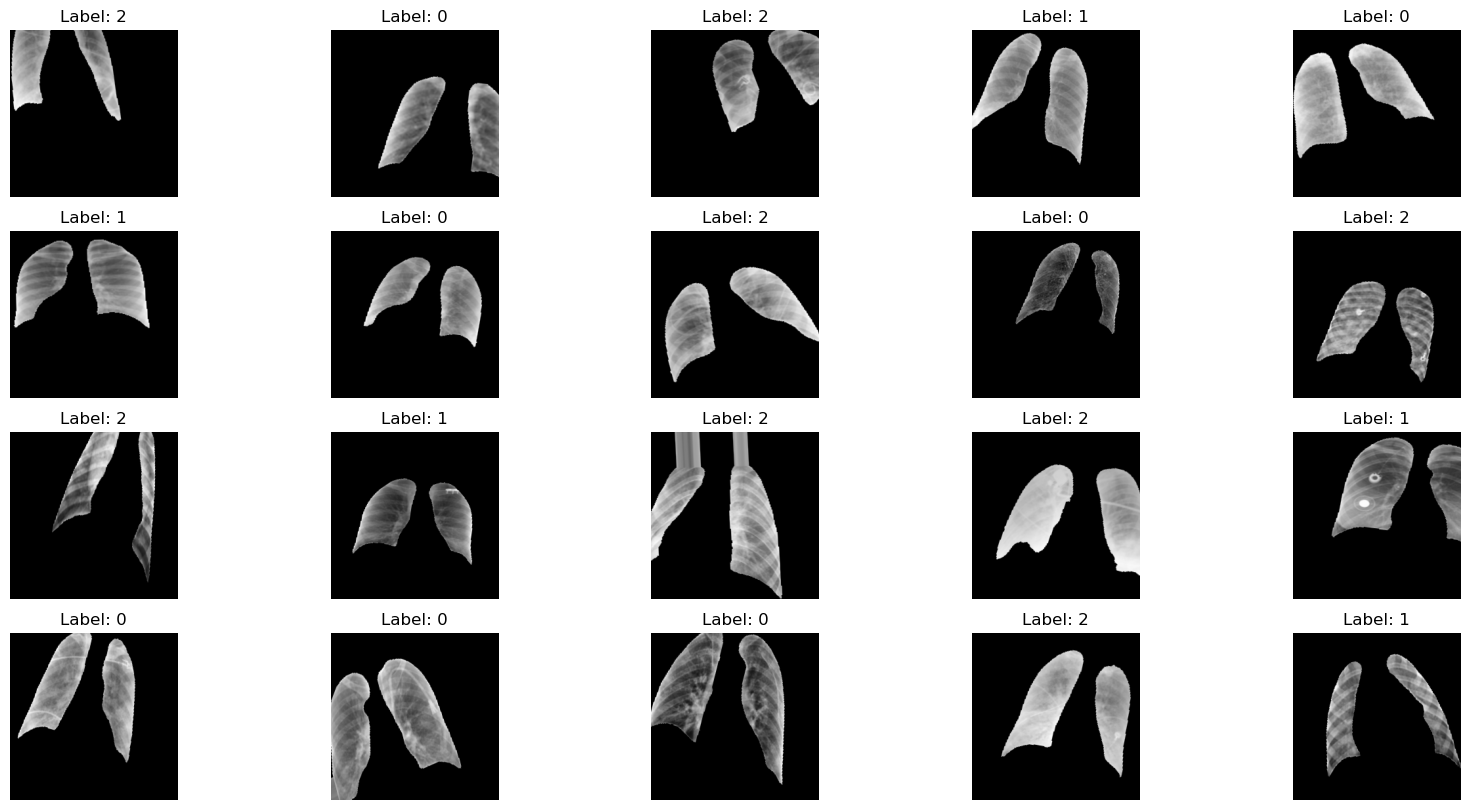

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 127, 127,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 125, 125,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 125, 125,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 62, 62,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 62, 62,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 60, 60,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 24,433,443 (93.21 MB)

 Trainable params: 2,627,587 (10.02 MB)

 Non-trainable params: 21,805,856 (83.18 MB)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5914 - loss: 1.3091 - val_accuracy: 0.6791 - val_loss: 0.8122 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6427 - loss: 0.9056 - val_accuracy: 0.7376 - val_loss: 0.6419 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.6901 - loss: 0.7619 - val_accuracy: 0.7714 - val_loss: 0.5652 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7047 - loss: 0.6853 - val_accuracy: 0.7700 - val_loss: 0.5574 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.7211 - l

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(array_to_img(images[i]))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

augmented_images, augmented_labels = next(train_generator)
plot_images(augmented_images, augmented_labels)

base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model2.trainable = False

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model2.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr, lr_schedule]

history = model.fit(train_generator, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=callbacks)


Accuracy sur l'ensemble d'entraînement : 0.8134645223617554
162/162 ━━━━━━━━━━━━━━━━━━━━ 142s 858ms/step
Classification Report (Ensemble d'entraînement) :
              precision    recall  f1-score   support

       COVID       0.86      0.69      0.76      1685
      Normal       0.75      0.94      0.83      1750
   Pneumonia       0.86      0.81      0.84      1749

    accuracy                           0.81      5184
   macro avg       0.82      0.81      0.81      5184
weighted avg       0.82      0.81      0.81      5184

Accuracy sur l'ensemble de test : 0.7902790307998657
70/70 ━━━━━━━━━━━━━━━━━━━━ 61s 871ms/step
Classification Report (Ensemble de test) :
              precision    recall  f1-score   support

       COVID       0.84      0.63      0.72       722
      Normal       0.73      0.93      0.82       750
   Pneumonia       0.84      0.80      0.82       750

    accuracy                           0.79      2222
   macro avg       0.80      0.79      0.79      2222


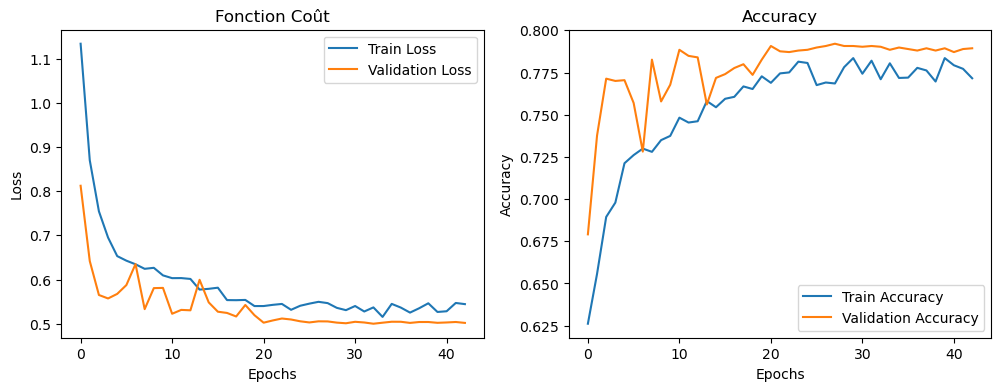

In [16]:
# Évaluation sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Accuracy sur l'ensemble d'entraînement : {train_accuracy}")
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred, target_names=['COVID', 'Normal', 'Pneumonia']))

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy sur l'ensemble de test : {test_accuracy}")
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred, target_names=['COVID', 'Normal', 'Pneumonia']))

# Tracer les courbes de la fonction coût et de l'accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fonction Coût')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

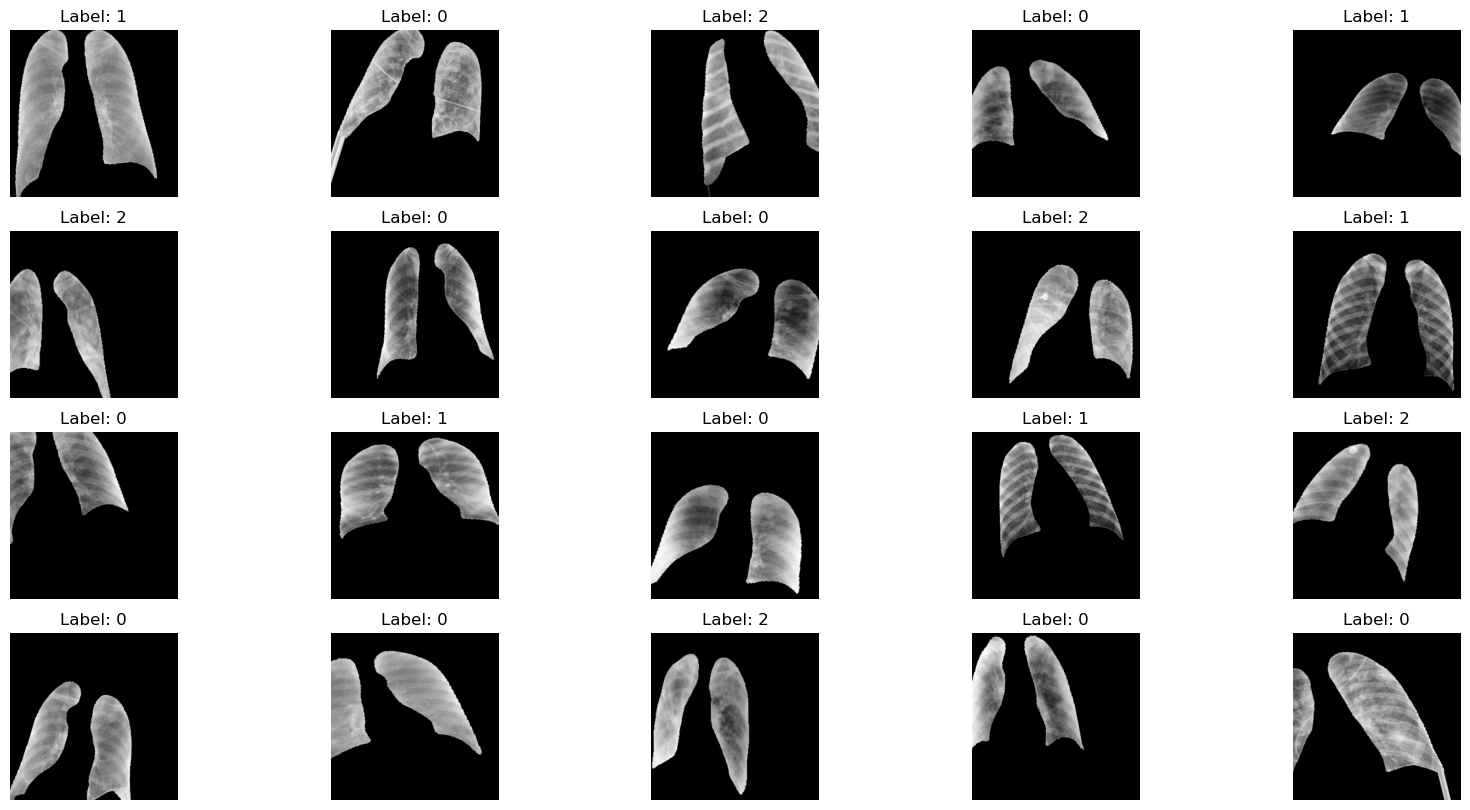

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 127, 127,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 125, 125,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 125, 125,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 62, 62,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 62, 62,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 60, 60,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/100


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5437 - loss: 1.3025 - val_accuracy: 0.7058 - val_loss: 0.6916
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.6439 - loss: 0.7887 - val_accuracy: 0.6871 - val_loss: 0.7271
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.7089 - loss: 0.6937 - val_accuracy: 0.6924 - val_loss: 0.6872
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.6837 - loss: 0.7312 - val_accuracy: 0.7333 - val_loss: 0.6374
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.6976 - loss: 0.6947 - val_accuracy: 0.6987 - val_loss: 0.6863
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.7024 - loss: 0.6809 - val_accuracy: 0.7396 - val_loss: 0.6119
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7012 - loss: 0.6789 - val_accuracy: 0.7302 - val_loss: 0.6259
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7106 - loss: 0.6714 - val_accuracy

In [12]:
# Inception v3 

# Divission des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Création d'un générateur de données pour l'entraînement
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# Visualiser quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(array_to_img(images[i]))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage d'images augmentées
augmented_images, augmented_labels = next(train_generator)
plot_images(augmented_images, augmented_labels)
plt.show()

# Chargement de InceptionV3 avec des poids pré-entraînés, en excluant la couche supérieure
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Geler le modèle de base
base_model.trainable = False

# Ajout de nouvelles couches supérieures
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Définition du modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle avec l'augmentation de données
history = model.fit(train_generator, epochs=EPOCHS, validation_data=(X_test, y_test))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Précision sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Rapport de classification (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Précision sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Rapport de classification (Ensemble de test) :")
print(classification_report(y_test, test_pred))




Accuracy sur l'ensemble d'entraînement :
0.8104761838912964
165/165 ━━━━━━━━━━━━━━━━━━━━ 137s 827ms/step
Classification Report (Ensemble d'entraînement) :
              precision    recall  f1-score   support

       COVID       0.85      0.70      0.77      1716
      Normal       0.75      0.93      0.83      1760
   Pneumonia       0.86      0.79      0.83      1774

    accuracy                           0.81      5250
   macro avg       0.82      0.81      0.81      5250
weighted avg       0.82      0.81      0.81      5250

Accuracy sur l'ensemble de test :
0.7871111035346985
71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 978ms/step
Classification Report (Ensemble de test) :
              precision    recall  f1-score   support

       COVID       0.83      0.67      0.74       784
      Normal       0.72      0.92      0.81       740
   Pneumonia       0.84      0.77      0.81       726

    accuracy                           0.79      2250
   macro avg       0.80      0.79      0.79      2250


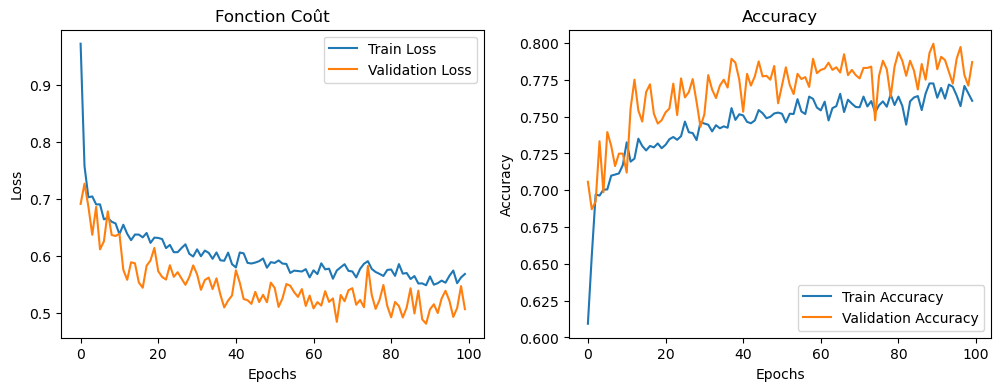

In [13]:
# Évalueation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred, target_names=['COVID', 'Normal', 'Pneumonia']))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred, target_names=['COVID', 'Normal', 'Pneumonia']))

# Courbes de la fonction coût et de l'accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fonction Coût')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
# Fonction Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM sur une image
def apply_gradcam(image, model, last_conv_layer_name, output_path):
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
    plt.matshow(heatmap)
    plt.title("Heatmap Grad-CAM")
    plt.show()

    def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
        img = array_to_img(img_array)
        heatmap = np.uint8(255 * heatmap)
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.size[1], img.size[0]))
        jet_heatmap = img_to_array(jet_heatmap)
        superimposed_img = jet_heatmap * alpha + img_array
        superimposed_img = array_to_img(superimposed_img)
        superimposed_img.save(cam_path)
        display(Image(cam_path))

    save_and_display_gradcam(image, heatmap, output_path)

In [21]:
for layer in base_model.layers:
    print(layer.name)

input_layer_2
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200


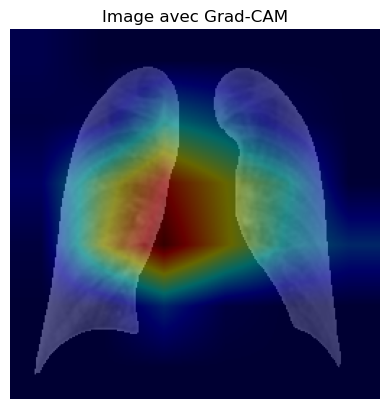

In [32]:
# Fonction Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM sur une image
def apply_gradcam(image, model, last_conv_layer_name, output_path):
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)

    # Utilisation cv2 pour redimensionner et superposer la heatmap
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convertir la heatmap en 8 bits
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Conversion de l'image d'origine en 8 bits pour être compatible avec la heatmap
    image = np.uint8(255 * image)

    # Superposition de la heatmap sur l'image d'origine
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Sauvegarde de l'image superposée
    cv2.imwrite(output_path, superimposed_img)

    # Affichage de l'image superposée
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Image avec Grad-CAM")
    plt.axis('off')
    plt.show()

# Exemple d'utilisation de Grad-CAM sur une image
sample_image = X_test[15]  # Utiliser une image de l'ensemble de test
apply_gradcam(sample_image, model, "mixed10", "gradcam_output.jpg")

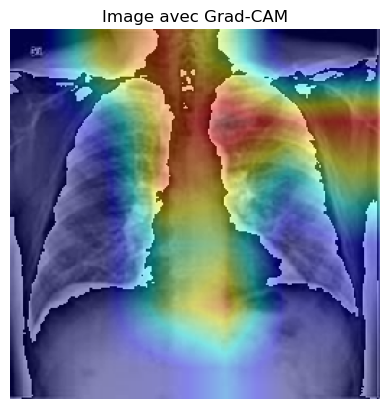

In [51]:
# Fonction Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM sur une image
def apply_gradcam(image, model, last_conv_layer_name, output_path):
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)

    # Utilisation cv2 pour redimensionner et superposer la heatmap
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convertir la heatmap en 8 bits
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Conversion de l'image d'origine en 8 bits pour être compatible avec la heatmap
    image = np.uint8(255 * image)

    # Superposition de la heatmap sur l'image d'origine
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Sauvegarde de l'image superposée
    cv2.imwrite(output_path, superimposed_img)

    # Affichage de l'image superposée
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Image avec Grad-CAM")
    plt.axis('off')
    plt.show()

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Exemple d'utilisation de Grad-CAM sur une image choisie
img_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/images/COVID-98.png' # Remplacez par le chemin de votre image
sample_image = load_and_preprocess_image(img_path)
apply_gradcam(sample_image, model, "mixed10", "gradcam_output.jpg")

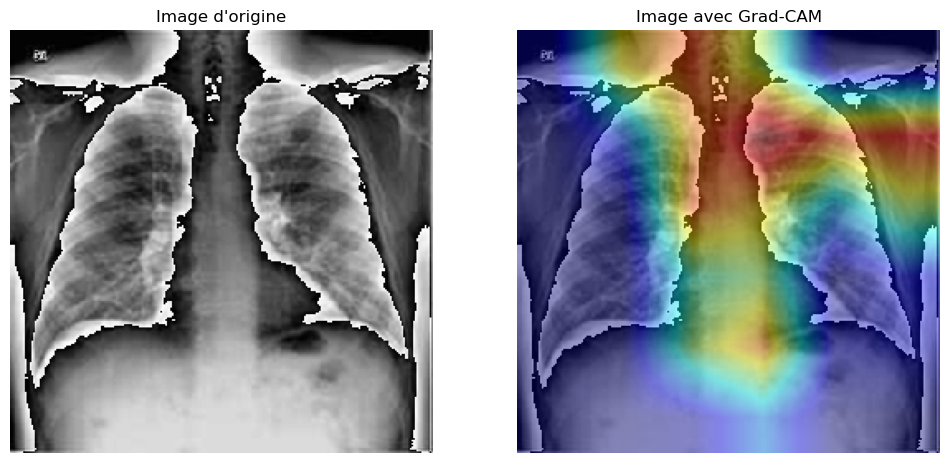

In [52]:
# Fonction Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM à une image
def apply_gradcam(image, model, last_conv_layer_name, output_path):
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)

    # Utilisation de cv2 pour redimensionner et superposer la heatmap
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convertir la heatmap en 8 bits
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Conversion l'image d'origine en 8 bits pour être compatible avec la heatmap
    image = np.uint8(255 * image)

    # Superposition de la heatmap sur l'image d'origine
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Affichage de l'image d'origine et l'image superposée côte à côte
    plt.figure(figsize=(12, 6))

    # Affichage de l'image d'origine
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image d'origine")
    plt.axis('off')

    # Affichage de l'image avec Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Image avec Grad-CAM")
    plt.axis('off')

    plt.show()

    # Sauvegarde de l'image superposée
    cv2.imwrite(output_path, superimposed_img)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Exemple d'utilisation de Grad-CAM sur une image choisie
img_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/images/COVID-98.png' # Remplacez par le chemin de votre image
sample_image = load_and_preprocess_image(img_path)
apply_gradcam(sample_image, model, "mixed10", "gradcam_output.jpg")

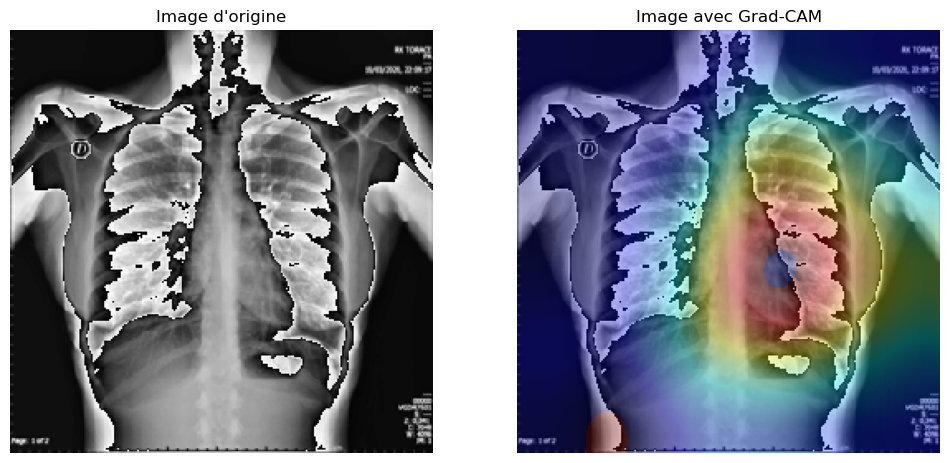

In [71]:
# Paramètres
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Chargement du modèle de base sans la couche supérieure
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Ajout d'une nouvelle tête personnalisée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Ajustez selon le nombre de classes
model = Model(inputs=base_model.input, outputs=x)

# Fonction Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Appliquation de Grad-CAM à une image
def apply_gradcam(image, model, last_conv_layer_name, output_path):
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)

    # Utilisation de cv2 pour redimensionner et superposer la heatmap
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
    heatmap = np.uint8(255 * heatmap)  # Convertir la heatmap en 8 bits
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Conversion l'image d'origine en 8 bits pour être compatible avec la heatmap
    image = np.uint8(255 * image)

    # Superposition la heatmap sur l'image d'origine
    superimposed_img = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)

    # Affichage l'image d'origine et l'image superposée côte à côte
    plt.figure(figsize=(12, 6))

    # Affichage de l'image d'origine
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image d'origine")
    plt.axis('off')

    # Affichage de l'image avec Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Image avec Grad-CAM")
    plt.axis('off')

    plt.show()

    # Sauvegarde de l'image superposée
    cv2.imwrite(output_path, superimposed_img)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Exemple d'utilisation de Grad-CAM sur une image choisie
img_path = '/Users/adamj/Downloads/COVID-19_Radiography_Dataset/COVID/images/COVID-22.png'  # Remplacez par le chemin de votre image
sample_image = load_and_preprocess_image(img_path)
apply_gradcam(sample_image, model, "mixed10", "gradcam_output.jpg")

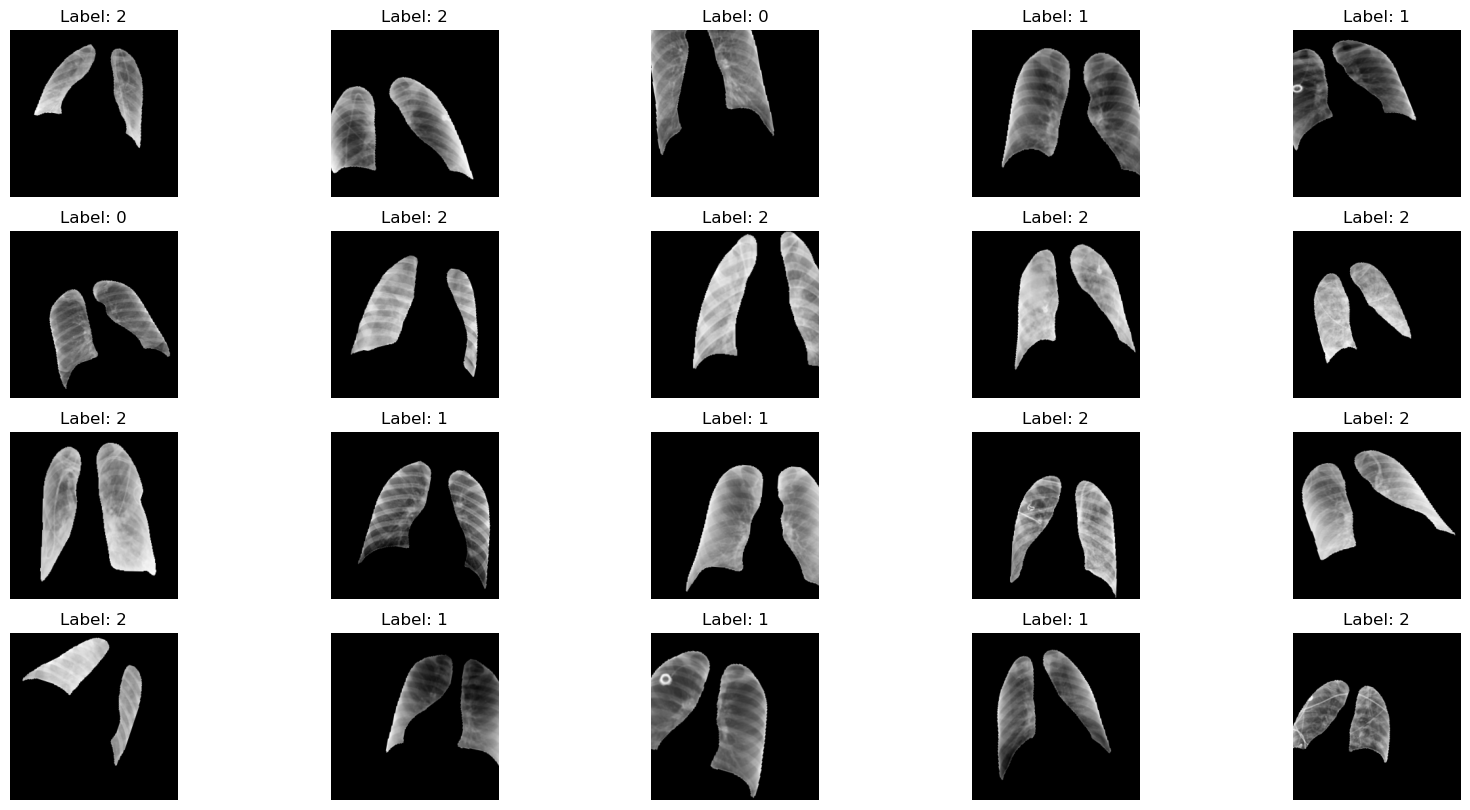

c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.4550 - loss: 1.2782 - val_accuracy: 0.3484 - val_loss: 2.0946
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.6399 - loss: 0.8113 - val_accuracy: 0.3489 - val_loss: 3.0980
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6518 - loss: 0.7532 - val_accuracy: 0.5173 - val_loss: 1.0185
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6549 - loss: 0.7615 - val_accuracy: 0.6947 - val_loss: 0.7013
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.6995 - loss: 0.6837 - val_accuracy: 0.5916 - val_loss: 0.8981
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.6998 - loss: 0.6907 - val_accuracy: 0.6929 - val_loss: 0.6963
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.7144 - loss: 0.6624 - val_accuracy: 0.7293 - val_loss: 0.5840
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.7264 - loss: 0.6540 - val_accuracy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,448,779 (16.97 MB)

 Trainable params: 1,482,307 (5.65 MB)

 Non-trainable params: 1,856 (7.25 KB)

 Optimizer params: 2,964,616 (11.31 MB)

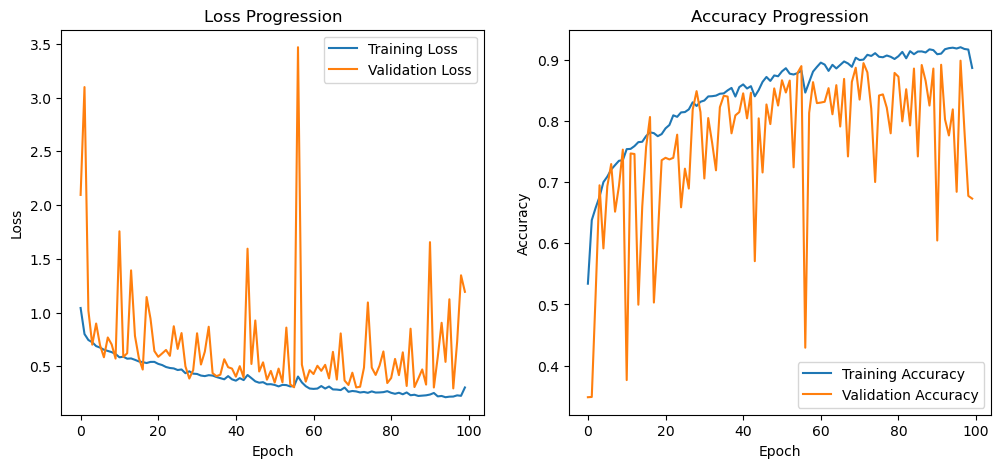

In [8]:
#CNN 256 12 couches 100 epoch

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# Visualize some augmented images
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        img = array_to_img(images[i])  # Convert array to image
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Display some augmented images
augmented_images, augmented_labels = next(train_generator)
plot_images(augmented_images, augmented_labels)

# Define the CNN model with 12 layers and 256 filters
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilation du modèle 
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrainement du modèle avec données augmentées
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)

# Evaluation du modèle d'entrainement  
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Evaluation du modèle sur l'ensemble test 
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred))

# Résumé du modèle
model.summary()

# Visualisation de la progression de la fonction coût et de la précision
plt.figure(figsize=(12, 5))

# Visualiser la fonction coût
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.legend()

# Visualiser la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Progression')
plt.legend()

plt.show()

In [8]:
#CNN 256 ResNet 
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Augmentation de données avancées
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training')
validation_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation')

# Fine-tuning avec ResNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compiler le modèle
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy sur l'ensemble de test : {test_accuracy}")

# Prédictions et rapport de classification
y_pred_train = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, y_pred_train))

y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, y_pred))

# Afficher le résumé du modèle
model.summary()

# Visualiser la progression de la fonction coût et de la précision
plt.figure(figsize=(12, 5))

# Visualiser la fonction coût
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Coût')
plt.title('Progression de la Fonction Coût')
plt.legend()

# Visualiser la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.title('Progression de la Précision')
plt.legend()

plt.show()

Epoch 1/50


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3230 - loss: 1.9160 - val_accuracy: 0.3171 - val_loss: 1.1887 - learning_rate: 0.0010
Epoch 2/50


c:\Users\adamj\Anaconda3\envs\myproject\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

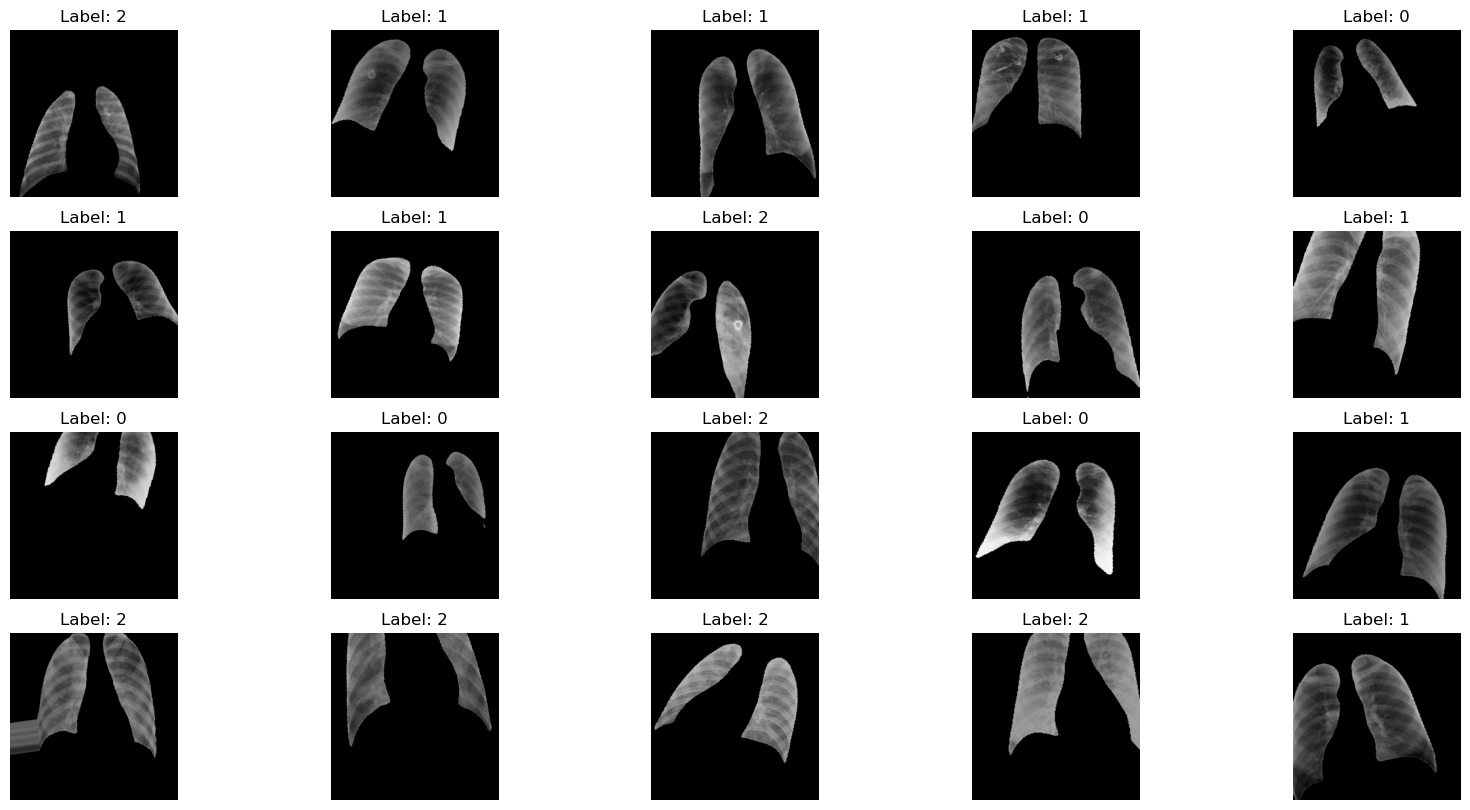

c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 154s 910ms/step - accuracy: 0.3480 - loss: 1.1686 - val_accuracy: 0.4942 - val_loss: 1.0202
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 165s 984ms/step - accuracy: 0.4853 - loss: 0.9951 - val_accuracy: 0.5667 - val_loss: 0.8998
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.5587 - loss: 0.9216 - val_accuracy: 0.6298 - val_loss: 0.8136
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 971s 6s/step - accuracy: 0.5901 - loss: 0.8870 - val_accuracy: 0.6498 - val_loss: 0.7821
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 134s 798ms/step - accuracy: 0.5981 - loss: 0.8718 - val_accuracy: 0.6324 - val_loss: 0.8251
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6116 - loss: 0.8323 - val_accuracy: 0.6387 - val_loss: 0.8196
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.6212 - loss: 0.8170 - val_accuracy: 0.6827 - val_loss: 0.7396
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.6418 - loss: 0.8004 - val_accura

In [7]:
#CNN 256 12 couches 50 epoch
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Visualisation de quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données augmentées
history = model.fit(train_generator, epochs=50, validation_data=(X_test, y_test))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.e
valuate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,241,739 (298.47 MB)

 Trainable params: 26,080,579 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,161,160 (198.98 MB)

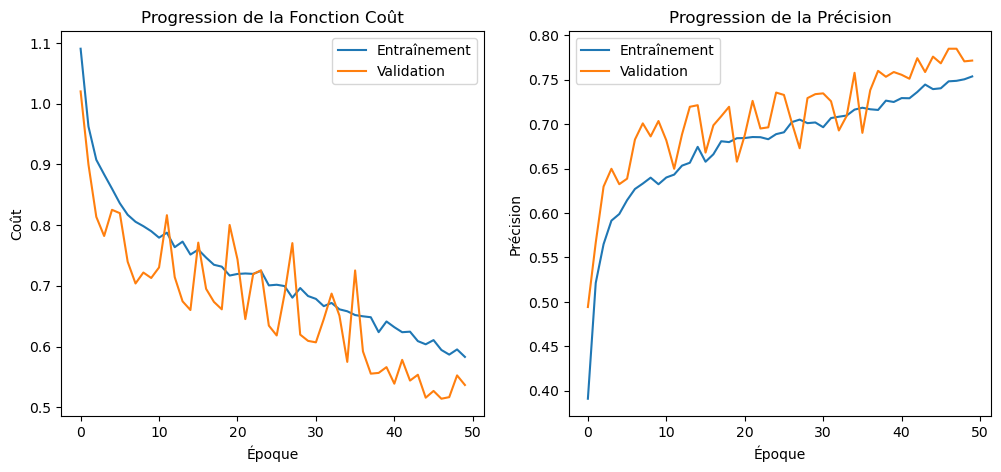

In [9]:
# Résumé du modèle
model.summary()

# Visualisation de la progression de la fonction coût et de la précision
plt.figure(figsize=(12, 5))

# Visualiser la fonction coût
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Coût')
plt.title('Progression de la Fonction Coût')
plt.legend()

# Visualisation de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.title('Progression de la Précision')
plt.legend()

plt.show()



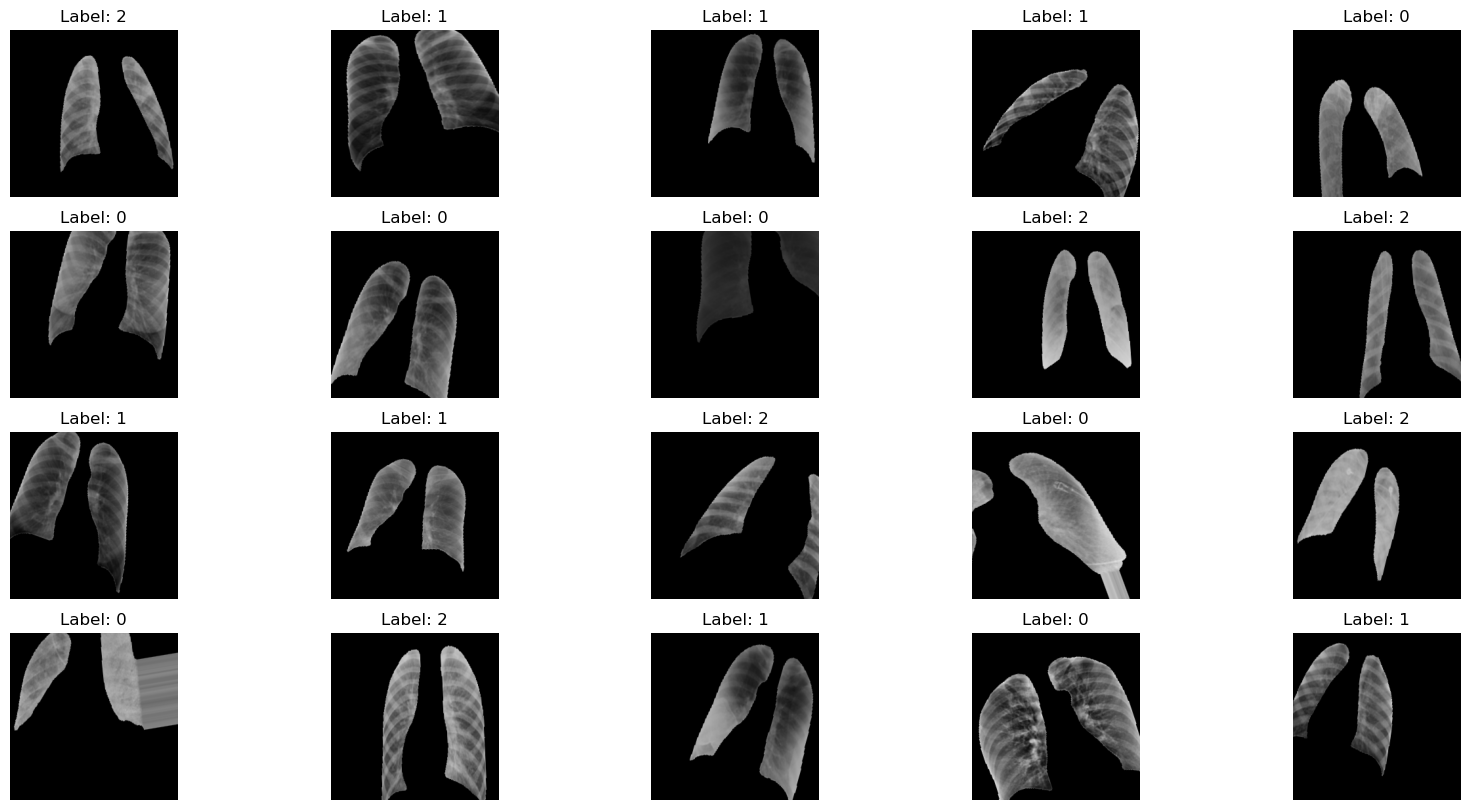

Epoch 1/10


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 149s 882ms/step - accuracy: 0.3586 - loss: 1.1339 - val_accuracy: 0.4107 - val_loss: 1.0912
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 142s 843ms/step - accuracy: 0.5051 - loss: 1.0049 - val_accuracy: 0.6218 - val_loss: 0.8230
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 138s 820ms/step - accuracy: 0.5710 - loss: 0.9067 - val_accuracy: 0.6098 - val_loss: 0.8558
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.6023 - loss: 0.8567 - val_accuracy: 0.6693 - val_loss: 0.7602
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 162s 965ms/step - accuracy: 0.6229 - loss: 0.7917 - val_accuracy: 0.6853 - val_loss: 0.6892
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 166s 994ms/step - accuracy: 0.6335 - loss: 0.7857 - val_accuracy: 0.6867 - val_loss: 0.7232
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.6585 - loss: 0.7468 - val_accuracy: 0.6436 - val_loss: 0.8557
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.6642 - loss: 0.7657 - val_

In [9]:
#CNN 256 12 couches
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'augmentation de données
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Visualisation quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données augmentées
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred))

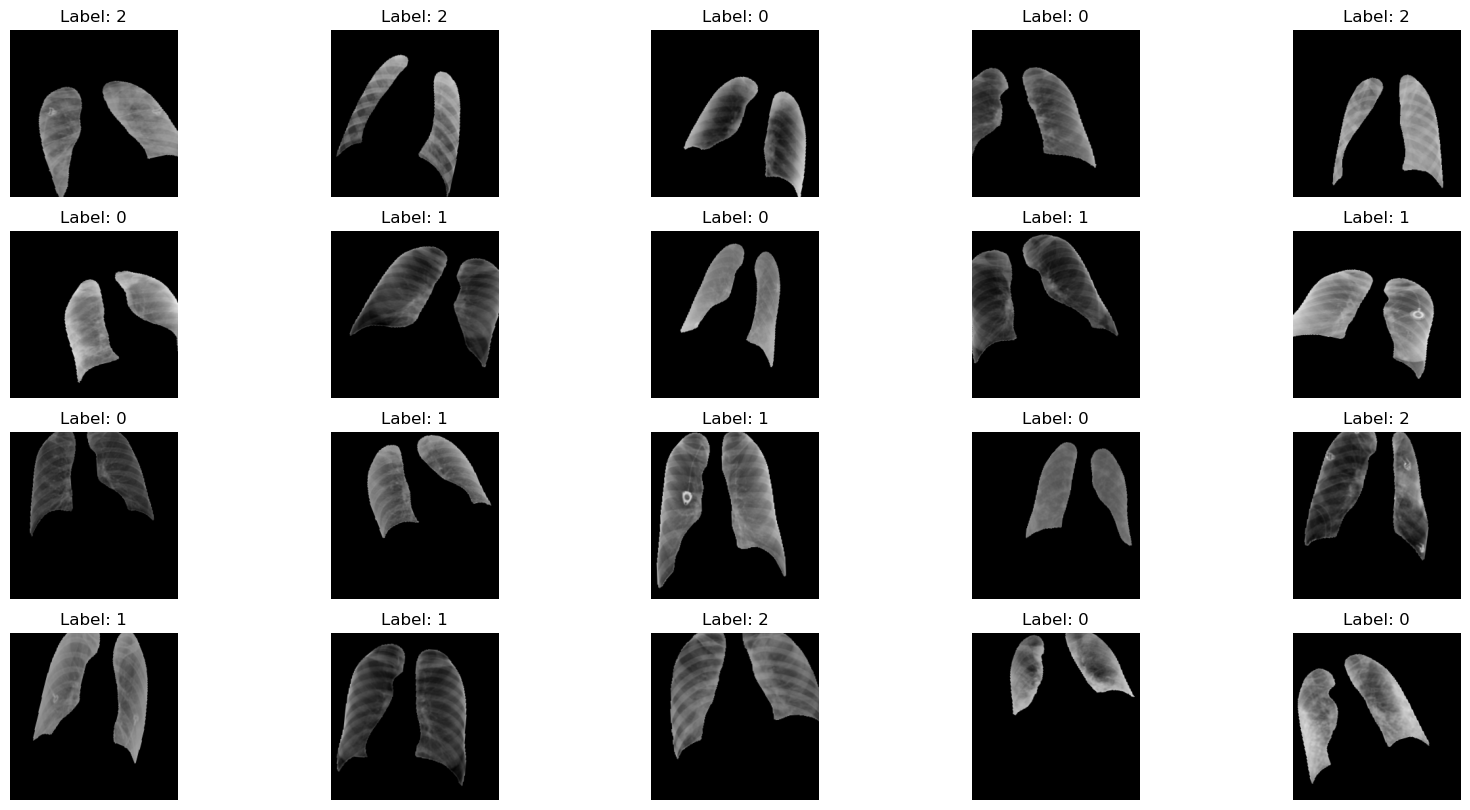

c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 127s 751ms/step - accuracy: 0.3502 - loss: 1.1376 - val_accuracy: 0.5187 - val_loss: 1.0391
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 116s 687ms/step - accuracy: 0.4815 - loss: 1.0333 - val_accuracy: 0.5724 - val_loss: 0.9198
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 116s 689ms/step - accuracy: 0.5485 - loss: 0.9570 - val_accuracy: 0.6142 - val_loss: 0.8359
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 114s 681ms/step - accuracy: 0.5742 - loss: 0.9114 - val_accuracy: 0.6351 - val_loss: 0.8385
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 117s 692ms/step - accuracy: 0.5939 - loss: 0.8937 - val_accuracy: 0.5720 - val_loss: 1.0818
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 117s 695ms/step - accuracy: 0.5933 - loss: 0.8864 - val_accuracy: 0.6507 - val_loss: 0.7948
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 115s 685ms/step - accuracy: 0.6264 - loss: 0.8367 - val_accuracy: 0.5689 - val_loss: 0.9546
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 118s 703ms/step - accuracy: 0.6362 - loss: 0.80

In [7]:
#CNN 256 6 couches
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'augmentation de données
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Visualisation de quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données augmentées
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred))

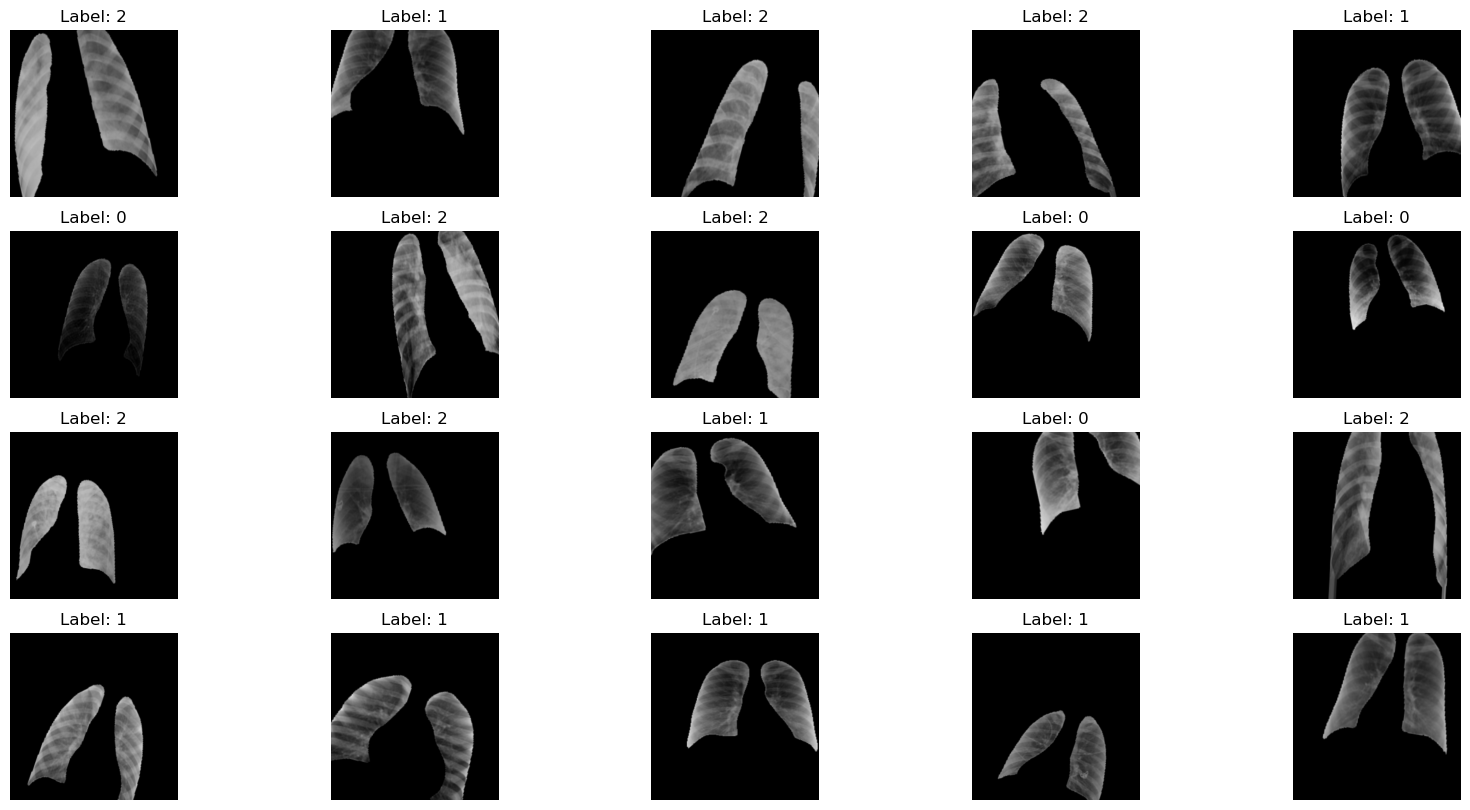

c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\adamj\Anaconda3\envs\myproject\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.3605 - loss: 1.1893 - val_accuracy: 0.5080 - val_loss: 1.0457
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.4560 - loss: 1.0425 - val_accuracy: 0.5916 - val_loss: 0.8762
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 160s 952ms/step - accuracy: 0.5378 - loss: 0.9670 - val_accuracy: 0.6053 - val_loss: 0.8492
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 162s 963ms/step - accuracy: 0.5705 - loss: 0.9177 - val_accuracy: 0.5840 - val_loss: 0.9277
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 162s 965ms/step - accuracy: 0.5760 - loss: 0.9107 - val_accuracy: 0.6218 - val_loss: 0.8681
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 164s 975ms/step - accuracy: 0.5922 - loss: 0.8899 - val_accuracy: 0.6573 - val_loss: 0.7783
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5892 - loss: 0.8762 - val_accuracy: 0.6062 - val_loss: 0.8629
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6073 - loss: 0.8359 - val_acc

In [11]:
#CNN 300
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'augmentation de données
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Visualisation de quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données augmentées
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy sur l'ensemble d'entraînement :")
print(train_accuracy)
train_pred = np.argmax(model.predict(X_train), axis=1)
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train, train_pred))

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy sur l'ensemble de test :")
print(test_accuracy)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, test_pred))

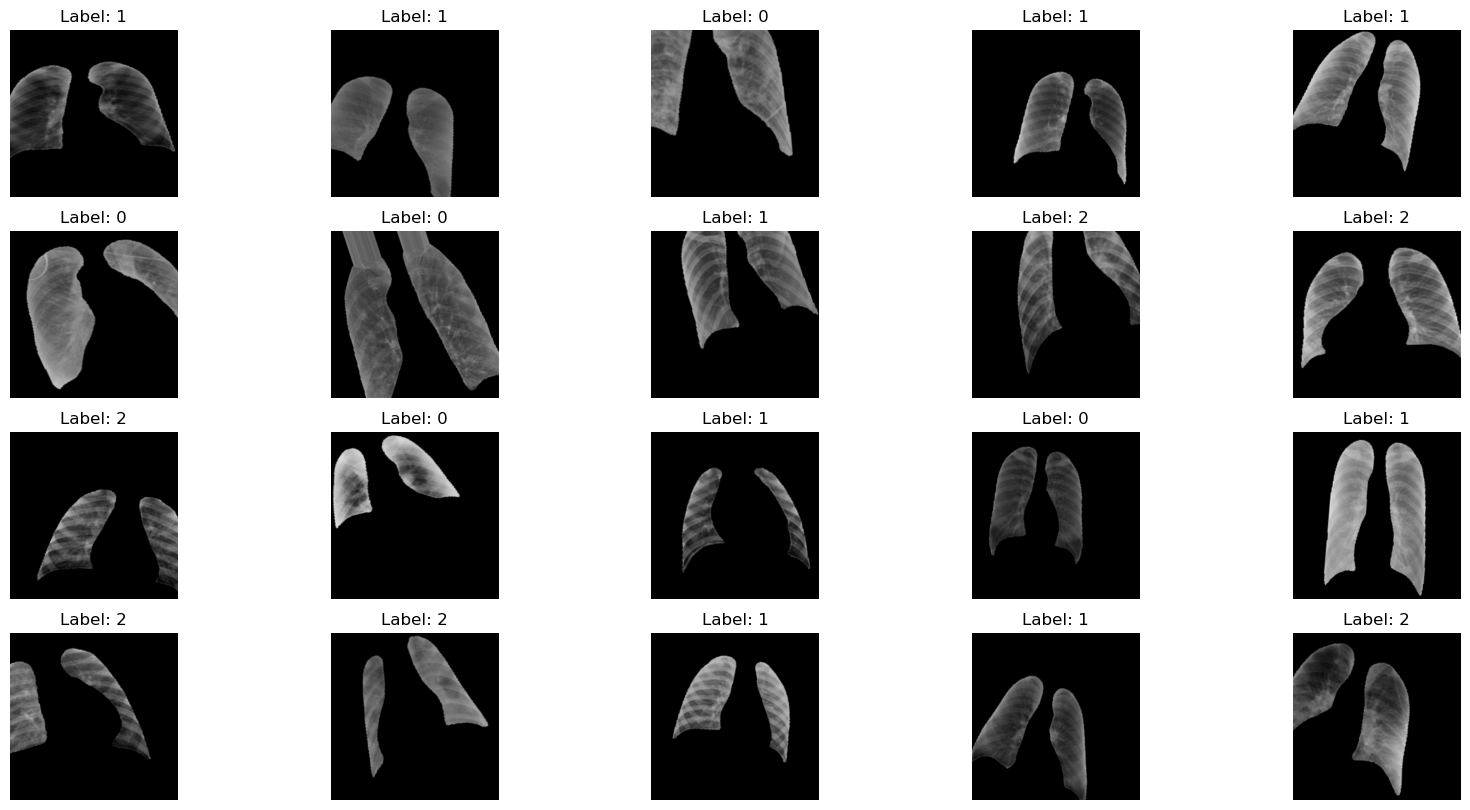

Accuracy sur l'ensemble d'entraînement :
1.0
Classification Report (Ensemble d'entraînement) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1716
           1       1.00      1.00      1.00      1760
           2       1.00      1.00      1.00      1774

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

Accuracy sur l'ensemble de test :
0.5782222222222222
Classification Report (Ensemble de test) :
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       784
           1       0.58      0.51      0.55       740
           2       0.59      0.67      0.63       726

    accuracy                           0.58      2250
   macro avg       0.58      0.58      0.58      2250
weighted avg       0.58      0.58      0.58      2250



In [8]:
#RF 300
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'augmentation de données
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Collecte des données augmentées
X_train_augmented = []
y_train_augmented = []

for i in range(len(train_generator)):
    aug_images, aug_labels = next(train_generator)
    X_train_augmented.extend(aug_images)
    y_train_augmented.extend(aug_labels)

# Conversion en numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Visualisation de quelques images augmentées
def plot_images(images, labels, n_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(4, n_images // 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Entraînement du modèle avec les données augmentées
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_augmented.reshape(X_train_augmented.shape[0], -1), y_train_augmented)

# Évaluation du modèle sur l'ensemble d'entraînement
y_train_pred = clf.predict(X_train_augmented.reshape(X_train_augmented.shape[0], -1))
print("Accuracy sur l'ensemble d'entraînement :")
print(accuracy_score(y_train_augmented, y_train_pred))
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train_augmented, y_train_pred))

# Évaluation du modèle sur l'ensemble de test
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
print("Accuracy sur l'ensemble de test :")
print(accuracy_score(y_test, y_pred))
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, y_pred))

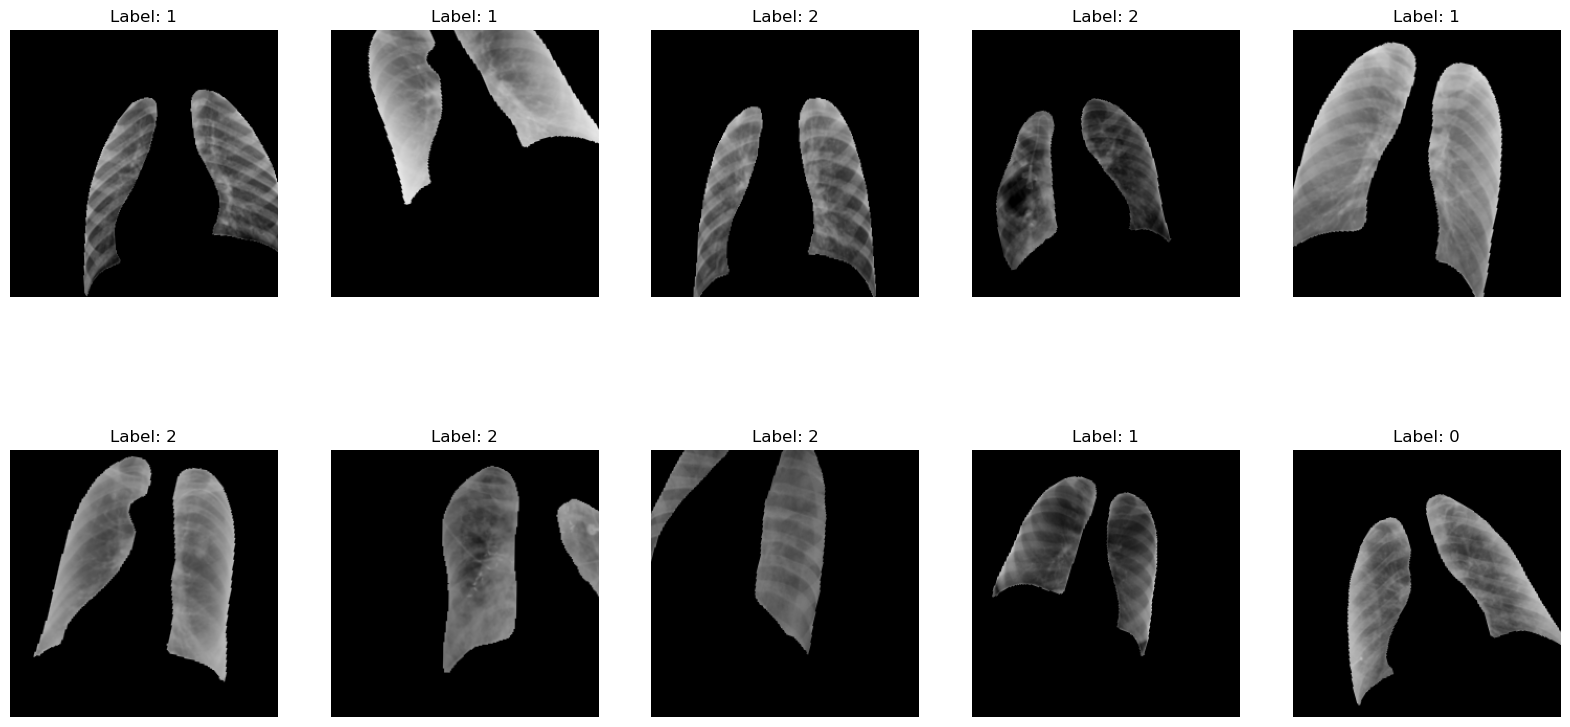

Accuracy sur l'ensemble d'entraînement :
1.0
Classification Report (Ensemble d'entraînement) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1716
           1       1.00      1.00      1.00      1760
           2       1.00      1.00      1.00      1774

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

Accuracy sur l'ensemble de test :
0.5835555555555556
Classification Report (Ensemble de test) :
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       784
           1       0.59      0.52      0.55       740
           2       0.61      0.67      0.64       726

    accuracy                           0.58      2250
   macro avg       0.58      0.58      0.58      2250
weighted avg       0.58      0.58      0.58      2250



In [8]:
#RF 256
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Configuration de ImageDataGenerator pour l'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'augmentation de données
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Collecte des données augmentées
X_train_augmented = []
y_train_augmented = []

for i in range(len(train_generator)):
    aug_images, aug_labels = next(train_generator)
    X_train_augmented.extend(aug_images)
    y_train_augmented.extend(aug_labels)

# Conversion en numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Visualisation de quelques images augmentées
def plot_images(images, labels, n_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        ax = plt.subplot(2, n_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

# Affichage de quelques images augmentées
augmented_images, augmented_labels = next(train_generator)

plot_images(augmented_images, augmented_labels)
plt.show()

# Entraînement du modèle avec les données augmentées
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_augmented.reshape(X_train_augmented.shape[0], -1), y_train_augmented)

# Évaluation du modèle sur l'ensemble d'entraînement
y_train_pred = clf.predict(X_train_augmented.reshape(X_train_augmented.shape[0], -1))
print("Accuracy sur l'ensemble d'entraînement :")
print(accuracy_score(y_train_augmented, y_train_pred))
print("Classification Report (Ensemble d'entraînement) :")
print(classification_report(y_train_augmented, y_train_pred))

# Évaluation du modèle sur l'ensemble de test
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
print("Accuracy sur l'ensemble de test :")
print(accuracy_score(y_test, y_pred))
print("Classification Report (Ensemble de test) :")
print(classification_report(y_test, y_pred))

In [12]:
# Augmentation of data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the images
datagen.fit(images)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Generate augmented data
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Create a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize the data
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Flatten the images for the classifier
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

# Train the model
pipeline.fit(X_train_flatten, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_flatten)
print("Accuracy on the test set:")
print(accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on the test set:
0.7213333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       784
           1       0.77      0.71      0.74       740
           2       0.75      0.72      0.74       726

    accuracy                           0.72      2250
   macro avg       0.73      0.72      0.72      2250
weighted avg       0.73      0.72      0.72      2250



In [16]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Augmentation des données avec ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_data(generator, images, labels, batch_size=32, augment_size=10000):
    aug_images = []
    aug_labels = []
    for x, y in generator.flow(images, labels, batch_size=batch_size):
        aug_images.extend(x)
        aug_labels.extend(y)
        if len(aug_images) >= augment_size:
            break
    return np.array(aug_images), np.array(aug_labels)

aug_X_train, aug_y_train = augment_data(datagen, X_train, y_train)

# Combiner les données augmentées avec les données originales
X_train_combined = np.concatenate((X_train, aug_X_train))
y_train_combined = np.concatenate((y_train, aug_y_train))

# Aplatir les images pour PCA
X_train_flatten = X_train_combined.reshape((X_train_combined.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

In [18]:
# Appliquation PCA
n_components = 3000
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flatten)
X_test_pca = pca.transform(X_test_flatten)

In [21]:
# Définition des hyperparamètres à tester
param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Création d'un pipeline avec StandardScaler, PCA et RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Configuration RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [22]:
# Exécuter RandomizedSearchCV
random_search.fit(X_train_pca, y_train_combined)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=3000)),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [50, 100,
                                                                     150]},
                   random_state=42, verbose=2)

In [23]:
# Meilleurs paramètres et score
print("Meilleurs paramètres trouvés :")
print(random_search.best_params_)
print("Meilleure précision obtenue :")
print(random_search.best_score_)

Meilleurs paramètres trouvés :
{'classifier__n_estimators': 150, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Meilleure précision obtenue :
0.3514529494323275


In [24]:
# 128 modèle sur l'ensemble de test
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
print("Accuracy sur l'ensemble de test :")
print(accuracy_score(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test, y_pred))

Accuracy sur l'ensemble de test :
0.39022222222222225
Classification Report :
              precision    recall  f1-score   support

           0       0.44      0.41      0.43       784
           1       0.38      0.38      0.38       740
           2       0.35      0.38      0.36       726

    accuracy                           0.39      2250
   macro avg       0.39      0.39      0.39      2250
weighted avg       0.39      0.39      0.39      2250



In [21]:
# Vérification des tailles des ensembles de données
print(f"Nombre d'images chargées: {images.shape[0]}")
print(f"Nombre de labels: {len(labels)}")

Nombre d'images chargées: 7500
Nombre de labels: 7500


In [22]:
# Aplatir les images pour les utiliser avec Random Forest
X = images.reshape(images.shape[0], -1)
y = labels

print(f"Taille de X après aplatissement: {X.shape}")
print(f"Taille de y: {len(y)}")

Taille de X après aplatissement: (7500, 49152)
Taille de y: 7500


In [23]:
# Encodage des étiquettes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [24]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_test: {X_test.shape}")
print(f"Taille de y_train: {len(y_train)}")
print(f"Taille de y_test: {len(y_test)}")

Taille de X_train: (5250, 49152)
Taille de X_test: (2250, 49152)
Taille de y_train: 5250
Taille de y_test: 2250


In [14]:

# Ajustement PCA sur les données
pca = PCA()
pca.fit(X_train)

PCA()

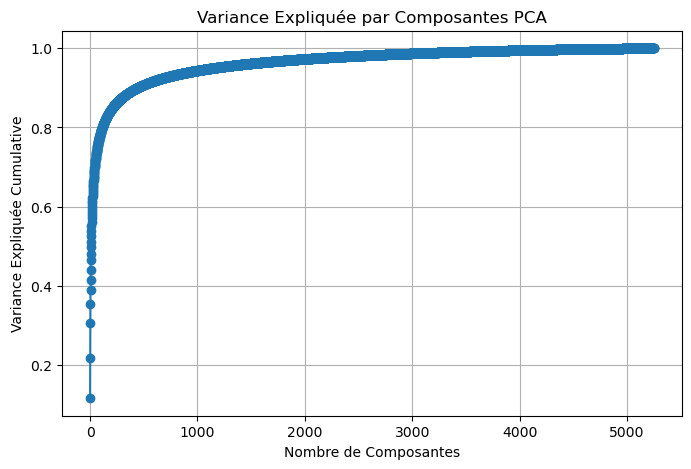

In [15]:
# Tracer la variance expliquée pour choisir le nombre optimal de composantes
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(explained_variance_ratio, marker='o')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulative')
plt.title('Variance Expliquée par Composantes PCA')
plt.grid(True)
plt.show()

In [10]:
# Choix du nombre de composants PCA (par exemple, 440 dans cet exemple)
n_components = 3000

# Réajustement PCA avec le nombre optimal de composants
pca = PCA(n_components=n_components)

In [25]:
# Étape 2 : Configuration RandomizedSearchCV
# Définition des hyperparamètres à tester
param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Création d'un pipeline avec PCA et RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalisation des données
    ('pca', pca),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Configuration RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Nombre d'itérations
    cv=5,  # Nombre de folds pour la validation croisée
    verbose=2,  # Niveau de verbosité
    random_state=42,
    n_jobs=-1  # Utiliser tous les cœurs disponibles
)

In [27]:
# Exécuter RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [23]:
from sklearn.decomposition import IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


# Choix du nombre de composants PCA
n_components = 3000

# Utilisation de IncrementalPCA
ipca = IncrementalPCA(n_components=n_components)

# Ajustement IncrementalPCA par morceaux pour économiser la mémoire
# Pour cela, passage des morceaux des données à fit()
ipca.fit(X_train)

MemoryError: Unable to allocate 7.69 GiB for an array with shape (5250, 196608) and data type float64

In [48]:
from sklearn.decomposition import PCA
# Modèle pca avec gridsearchcv 256
# Réduction la dimensionnalité des données
pca = PCA(n_components=0.9, random_state=42)  # Choisissez le nombre de composants à conserver ou la variance expliquée
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

print(f"Taille après PCA - X_train: {X_train_reduced.shape}")
print(f"Taille après PCA - X_test: {X_test_reduced.shape}")

Taille après PCA - X_train: (5250, 440)
Taille après PCA - X_test: (2250, 440)


In [49]:
# Définition de la grille des hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_depth': [10, 20, 30],       # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4]     # Nombre minimum d'échantillons dans un noeud feuille
}

clf = RandomForestClassifier(random_state=42)

In [50]:
from sklearn.model_selection import GridSearchCV

# Configuration GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleure précision: {grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Meilleure précision: 0.6361904761904762


In [51]:
# Prédiction sur l'ensemble de test avec le meilleur modèle
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_reduced)

from sklearn.metrics import accuracy_score, classification_report

# Évaluation de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test: {accuracy}")

# Classification report
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Accuracy sur l'ensemble de test: 0.6551111111111111
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       750
           1       0.66      0.71      0.68       750
           2       0.73      0.63      0.67       750

    accuracy                           0.66      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.66      0.66      0.66      2250



In [39]:
from sklearn.ensemble import RandomForestClassifier

# Création du modèle avec des hyperparamètres ajustés
clf = RandomForestClassifier(n_estimators=50,  # Réduit le nombre d'arbres
                             max_depth=10,    # Limite la profondeur des arbres
                             min_samples_split=5,  # Augmente le nombre minimum d'échantillons pour diviser un nœud
                             min_samples_leaf=5,   # Augmente le nombre minimum d'échantillons dans une feuille
                             random_state=42)

In [40]:
# 256 autres parametres
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [41]:
# 256 autres parametres train
y_train_pred = clf.predict(X_train)
print(f"Accuracy sur l'ensemble d'entraînement: {accuracy_score(y_train, y_train_pred)}")
print(f"Classification Report pour l'ensemble d'entraînement:\n {classification_report(y_train, y_train_pred)}")

Accuracy sur l'ensemble d'entraînement: 0.9295238095238095
Classification Report pour l'ensemble d'entraînement:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1750
           1       0.88      0.94      0.91      1750
           2       0.98      0.93      0.95      1750

    accuracy                           0.93      5250
   macro avg       0.93      0.93      0.93      5250
weighted avg       0.93      0.93      0.93      5250



In [42]:
# 256 autres parametres test
y_test_pred = clf.predict(X_test)
print(f"Accuracy sur l'ensemble de test: {accuracy_score(y_test, y_test_pred)}")
print(f"Classification Report pour l'ensemble de test:\n {classification_report(y_test, y_test_pred)}")

Accuracy sur l'ensemble de test: 0.7044444444444444
Classification Report pour l'ensemble de test:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67       750
           1       0.70      0.75      0.73       750
           2       0.79      0.66      0.72       750

    accuracy                           0.70      2250
   macro avg       0.71      0.70      0.71      2250
weighted avg       0.71      0.70      0.71      2250



In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)
print(f"Scores de validation croisée: {scores}")
print(f"Précision moyenne: {scores.mean()}")

Scores de validation croisée: [0.56       0.57933333 0.69933333 0.70066667 0.688     ]
Précision moyenne: 0.6454666666666666


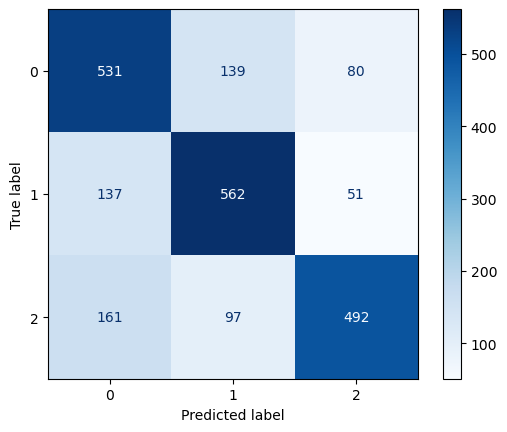

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred, labels=range(NUM_CLASSES))

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [34]:
# Créer et entraîner le modèle Random Forest
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [35]:

# Prédiction sur l'ensemble d'entraînement
y_train_pred = clf.predict(X_train)

In [36]:
# 256 avec 50 arbres train
print(f"Accuracy sur l'ensemble d'entraînement: {accuracy_score(y_train, y_train_pred)}")
print(f"Classification Report pour l'ensemble d'entraînement:\n{classification_report(y_train, y_train_pred)}")

Accuracy sur l'ensemble d'entraînement: 0.9998095238095238
Classification Report pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1750
           1       1.00      1.00      1.00      1750
           2       1.00      1.00      1.00      1750

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [38]:
# 256 avec 50 arbres test
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.7182222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68       750
           1       0.74      0.73      0.74       750
           2       0.79      0.71      0.74       750

    accuracy                           0.72      2250
   macro avg       0.72      0.72      0.72      2250
weighted avg       0.72      0.72      0.72      2250



In [30]:
# 256 avec 100 arbres train
print(f"Accuracy sur l'ensemble d'entraînement: {accuracy_score(y_train, y_train_pred)}")
print(f"Classification Report pour l'ensemble d'entraînement:\n{classification_report(y_train, y_train_pred)}")

Accuracy sur l'ensemble d'entraînement: 1.0
Classification Report pour l'ensemble d'entraînement:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1750
           1       1.00      1.00      1.00      1750
           2       1.00      1.00      1.00      1750

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250



In [37]:
# Prédiction sur l'ensemble de test
y_pred = clf.predict(X_test)

In [32]:
# 256 avec 100 arbres test
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.7324444444444445
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70       750
           1       0.75      0.73      0.74       750
           2       0.80      0.71      0.75       750

    accuracy                           0.73      2250
   macro avg       0.74      0.73      0.73      2250
weighted avg       0.74      0.73      0.73      2250



In [14]:
# 300 modèle
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 0.7315555555555555
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69       750
           1       0.74      0.75      0.74       750
           2       0.78      0.75      0.76       750

    accuracy                           0.73      2250
   macro avg       0.73      0.73      0.73      2250
weighted avg       0.73      0.73      0.73      2250



In [33]:
#256 sur 100 arbres validation croisée

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)  # Validation croisée avec 5 plis
print(f"Scores de validation croisée : {scores}")
print(f"Précision moyenne : {scores.mean()}")

Scores de validation croisée : [0.60866667 0.6        0.73       0.72       0.726     ]
Précision moyenne : 0.6769333333333334


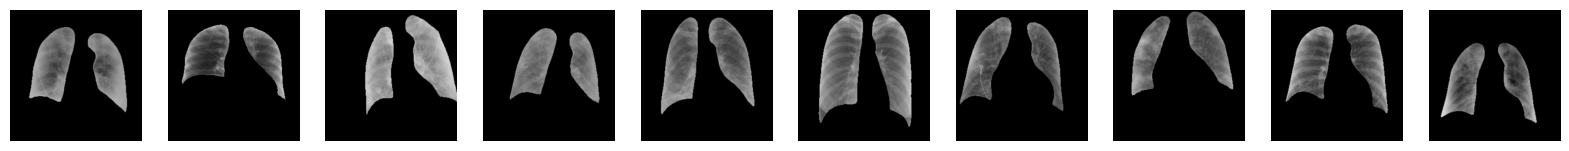

In [15]:
# Visualisation de quelques images avec masques appliqués
def visualize_images_with_masks(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

visualize_images_with_masks(images[:10])  # Visualiser les 10 premières images